# Meanshift and clustering

Clustering is a technique used for unsupervised learning. Meanshift is one of the algorithms used for this.

In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial
     
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

### Creating data

First we are creating the first 6 random locations that we will form data groupings about.  Then we are using multivariate normal to distribute a group of points evenly around that initial location (centroid)

In [2]:
n_clusters=6
n_samples =250
centroids = torch.rand(n_clusters, 2)*70-35

In [3]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor
     
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))
     
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [4]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

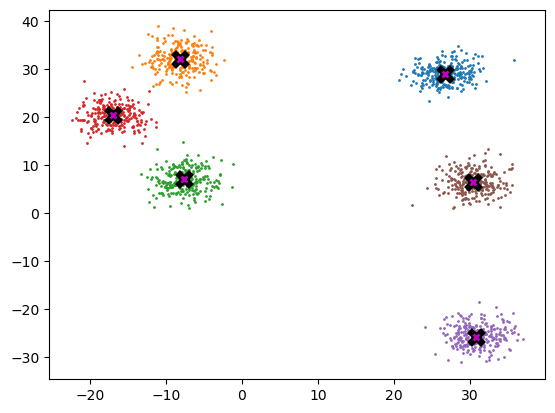

In [5]:
plot_data(centroids, data, n_samples)


## Mean shift

Mean shift is a clustering algorithm used as an unsupervised learning method.  It is similar to k-means but has the advantage that there is no need to specify the number of groups to cluster elements into.  Instead a bandwidth is specified.  The algorithm uses the weighted average of the distance from one point to all the others to move each element closer to the center of its group.  The bandwidth specifies the falloff for the weighted average.

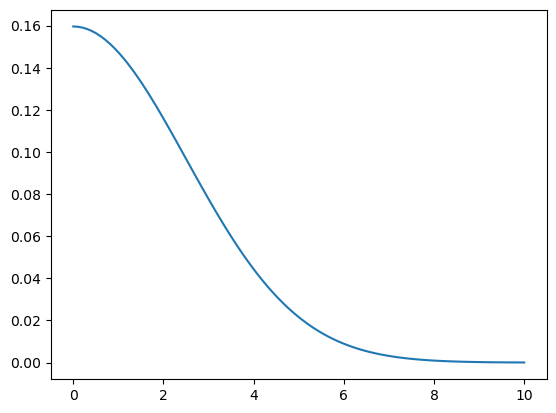

In [6]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

plot_func(partial(gaussian, bw=2.5))

In [24]:
X = data.clone()
x = data[0]
     
x.shape, X.shape

(torch.Size([2]), torch.Size([1500, 2]))

Our data is a set of 1500 two dimensional values (or locations).  `x` is our first location.

In [11]:
distance = ((x-X)**2).sum(1).sqrt()
distance[:8]

tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002])

In [31]:
from fastcore.test import test_close

In [28]:
((x-X)**2).shape

torch.Size([1500, 2])

In [33]:
distance2 = torch.einsum('ab->a', (x-X)**2).sqrt()
test_close(distance, distance2)

This is the distance from our first point `x` to every other point in the dataset


In [14]:
weight = gaussian(distance, 2.5)
weight

tensor([    0.160,     0.047,     0.025,  ...,     0.000,     0.000,     0.000])

These are the weights we will assign each element in the weighted average.  You can see point 0 (itself) has the highest weight. While elements far away (or past our 2.5 bandwidth) will barely affect the average at all (since as far as the 3 decimal points are concerned they are 0)

In [36]:
weight.shape, X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

these shapes are incompatible

In [38]:
weight[:,None].shape, X.shape

(torch.Size([1500, 1]), torch.Size([1500, 2]))

In [43]:
(weight[:,None]*X).sum(0)

tensor([406.866, 431.454])

these are compatible!

> On weighted average
> 
> Average is defined as the `(sum of values)/(number of values)`
> 
> Here we are using Weighted average which is defined as `(sum of each (value * weight)) / (sum of weights)`

In [44]:
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))
        weight = gaussian(dist, 2.5)
        X[i] = (weight[:,None]*X).sum(0) /weight.sum()

This one update moves each point to its weighted average.  By repeating this we move all points to their groups centroid.

In [ ]:
def meanshift(data):
    x=data.clone()
    for i in range(